# Credit scoring model


#### Objective : Create a credit scoring algorithm that predicts the chance of a given loan applicant defaulting on loan repayment.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

In [3]:
# Reading data
df = pd.read_csv("/content/drive/My Drive/Credit Data/Python Project/hmeq.csv")

In [4]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


# Understanding the data

In [5]:
df.shape

(5960, 13)

In [6]:
df.info()

# number of entries that are not Nan

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [7]:
df.isnull().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

In [8]:
df['JOB'].unique()

array(['Other', nan, 'Office', 'Sales', 'Mgr', 'ProfExe', 'Self'],
      dtype=object)

In [9]:
df['JOB'].value_counts()

Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64

In [10]:
df.describe()

# Descriptive stats
# Distribution of the data
# There are no anomalies in the data(observe the maximums and means in each case)

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [11]:
df.columns

# Columns of the dataset

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

## Distributions of various variables

0    4771
1    1189
Name: BAD, dtype: int64


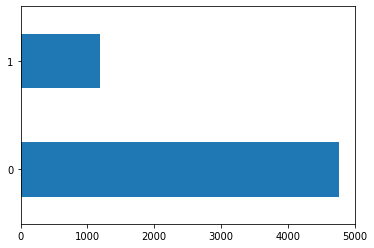

In [12]:
print(df["BAD"].value_counts())
df["BAD"].value_counts().plot(kind="barh")

# distribution of target variable "BAD"
# The target class is a bit unbalanced - zeroes are about 80% and ones are about 20%

In [13]:
print(df["REASON"].value_counts())

# This is a nominal feature, It must be modified in a way we can use it.

DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64


In [14]:
print(df["JOB"].value_counts())

# Same as the above case, we must find a way to use it.

Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64


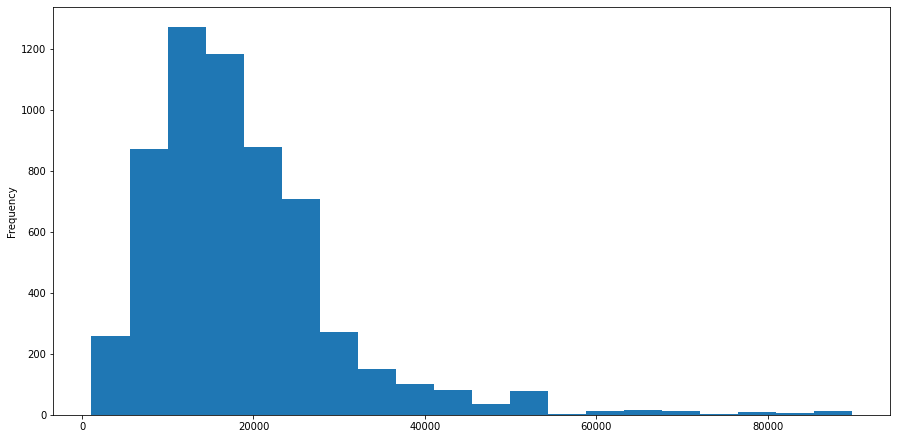

In [15]:
df["LOAN"].plot.hist(bins = 20,figsize=(15,7.5))

# distribution of loan variable
# density between 10000-30000 is high

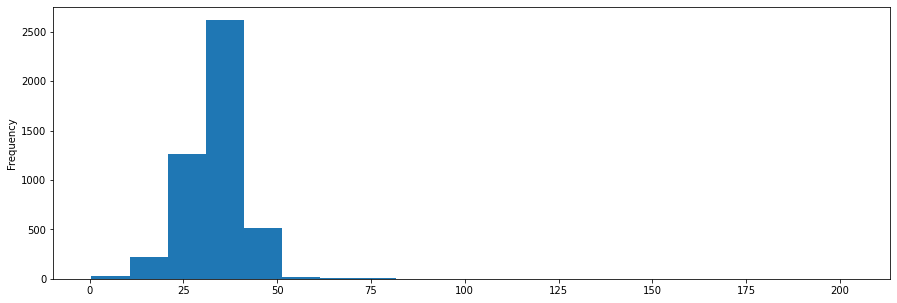

In [16]:
df["DEBTINC"].plot.hist(bins = 20,figsize=(15,5))
 
# Highly populated around 25-50
# We may cap off the end values if required.

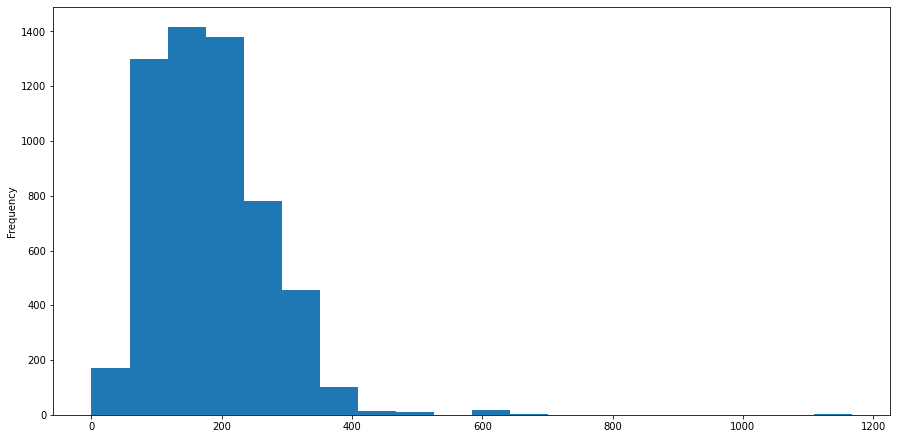

In [17]:
df["CLAGE"].plot.hist(bins = 20,figsize=(15,7.5))

# Density is high around 100-300
# We can cap off the values >= 600 to get better results

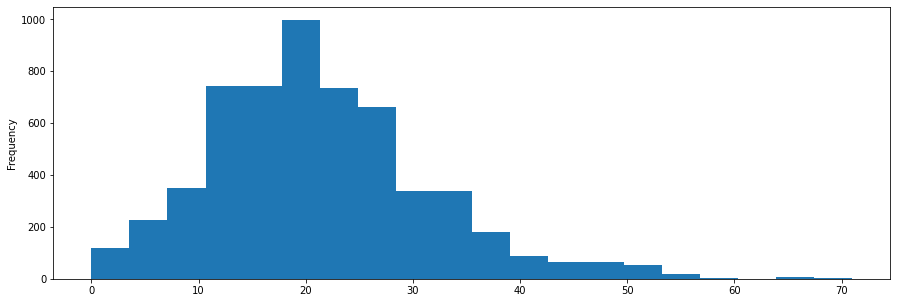

In [18]:
df["CLNO"].plot.hist(bins = 20,figsize=(15,5))

# This distribution looks good and we need not modify anything here.

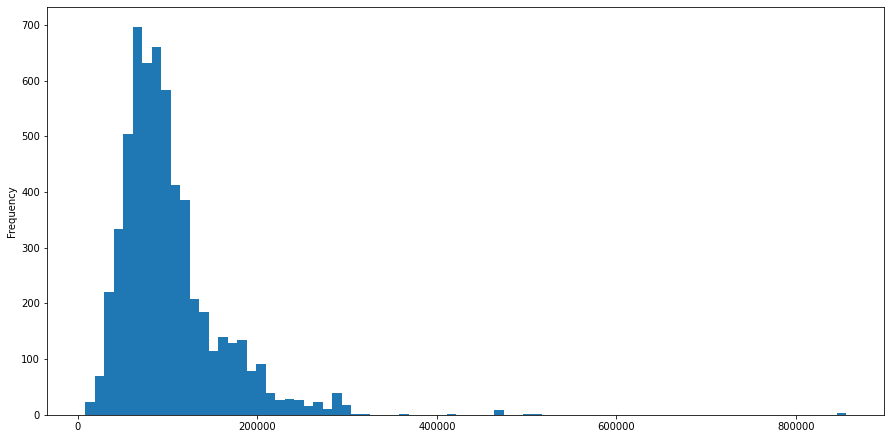

In [19]:
df["VALUE"].plot.hist(bins = 80,figsize=(15,7.5))

# Concentration is high around 80000-100000
# There are very less values at the end(>= 400000) that are a bit high compared to mean. We can cap these off.

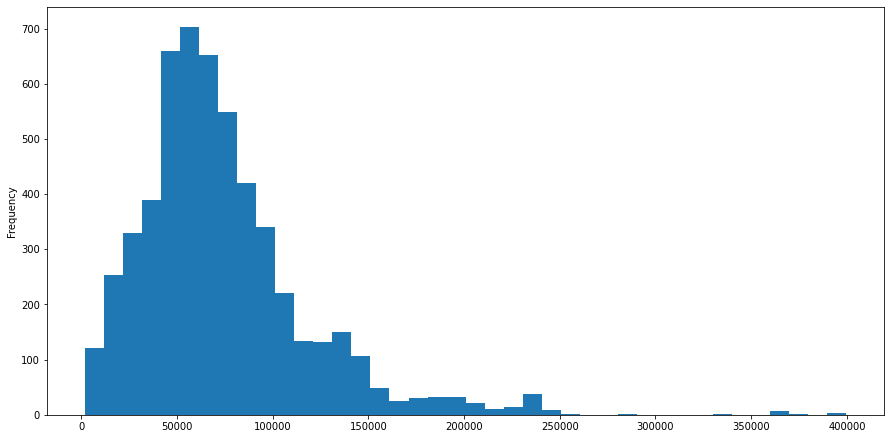

In [20]:
df["MORTDUE"].plot.hist(bins = 40,figsize=(15,7.5))

# Concentration is high around 40000-100000
# The values at the end(>= 300000) can be capped off.

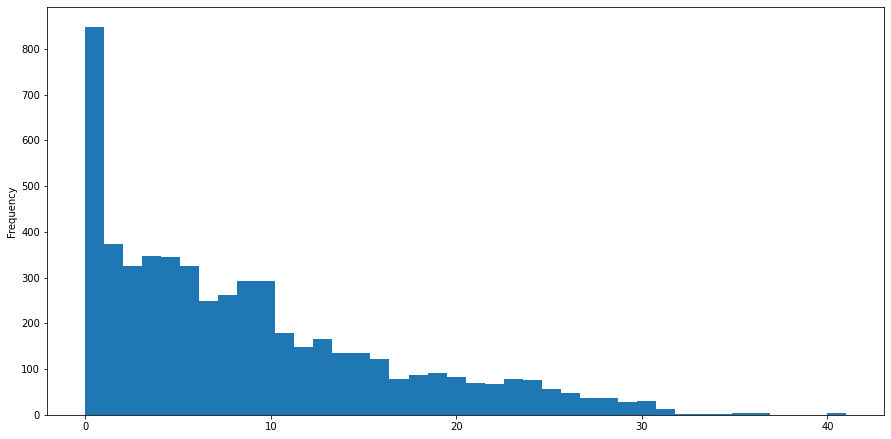

In [21]:
df["YOJ"].plot.hist(bins = 40,figsize=(15,7.5))

# This is very skewed. It would be better if we modify this variable to decrease the skewness.

In [22]:
df["DEROG"].value_counts()

# Derogatory incidents were reported only in few cases.
# So,creating a binary variable with values 1 for atleast one derogatory incident and 0 for no such report may be useful.

0.0     4527
1.0      435
2.0      160
3.0       58
4.0       23
6.0       15
5.0       15
7.0        8
8.0        6
9.0        3
10.0       2
Name: DEROG, dtype: int64

In [23]:
df["DELINQ"].value_counts()

# Most of them are zero.
# Same as in above case creating a binary variable would be useful.

0.0     4179
1.0      654
2.0      250
3.0      129
4.0       78
5.0       38
6.0       27
7.0       13
8.0        5
11.0       2
10.0       2
13.0       1
12.0       1
15.0       1
Name: DELINQ, dtype: int64

In [24]:
df["NINQ"].value_counts()

# Distributed mostly among first five values

0.0     2531
1.0     1339
2.0      780
3.0      392
4.0      156
5.0       75
6.0       56
7.0       44
10.0      28
8.0       22
9.0       11
11.0      10
13.0       2
12.0       2
17.0       1
14.0       1
Name: NINQ, dtype: int64

#### Conclusions :

- The distributions are fine and there are no anomalies in the data.
<br>
- DEBTINC has very high number of missing data(will be taken care of in next section - Imputing the variables).
<br>
- The feature YOJ is highly skewed and may be modified to decrease skewness.
<br>
- Nominal features : JOB and REASON must be modified in a way that we can use them for logistic regression model.
<br>
- DELINQ,DEROG may be divided into 2 classes to create new binary variables.
<br>
- VALUE,MORTDUE,CLAGE,DEBTINC may be capped off at the end that is values that are very high will be set to a selected lower value.
-------------------------------------------------------------------------------------------------------------------------------

# Imputing the input variables
<br>

In [25]:
df.isnull().sum()

# Number of cases with Nan.

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

#### Observations :
- Except in the case of DEBTINC, in all other cases only few values were not reported
- For imputing the missing values we can think of few ideas like :
    - In case of nominal features, replacing them with the majority class
    - In case of numeric variables like DEROG and DELINQ,most of the cases are 0.We can replace these with majority class.
    - In case of other numerical inputs , we can replace them by median or mean without modifying the much.In this   notebook I am going to replace them by mean of the respective column.

In [26]:
# Nominal features
# Replacement using majority class
# majority class in case of JOB variable is Other
# majority class in case of REASON varibale is DebtCon

df["REASON"].fillna(value = "DebtCon",inplace = True)
df["JOB"].fillna(value = "Other",inplace = True)

In [27]:
df["DEROG"].fillna(value=0,inplace=True)
df["DELINQ"].fillna(value=0,inplace=True)

In [28]:
# Numeric features
# Replacement using mean of each class

df.fillna(value=df.mean(),inplace=True)

In [29]:
df.isnull().sum()

# Checking if there is anything left out
# As you can see, all missing values are filled

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

##### Final look at the data after filling the missing values

In [30]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0000,39025.000000,HomeImp,Other,10.500000,0.0,0.0,94.366667,1.000000,9.000000,33.779915
1,1,1300,70053.0000,68400.000000,HomeImp,Other,7.000000,0.0,2.0,121.833333,0.000000,14.000000,33.779915
2,1,1500,13500.0000,16700.000000,HomeImp,Other,4.000000,0.0,0.0,149.466667,1.000000,10.000000,33.779915
3,1,1500,73760.8172,101776.048741,DebtCon,Other,8.922268,0.0,0.0,179.766275,1.186055,21.296096,33.779915
4,0,1700,97800.0000,112000.000000,HomeImp,Office,3.000000,0.0,0.0,93.333333,0.000000,14.000000,33.779915


# Applying the models on the data after imputation
- Applying the basic Classification on the data after replacement/imputation.Lets check the performnace by applying both Logistic Regression and Decision tree algorithms.
- Before applying the algorithms, The data is split into training and testing sets in the ratio 2:1 that is test data 33% and train data 67%.


In [31]:
# importing the required modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# removing the features BAD,JOB,REASON from the input features set
x_basic = df.drop(columns=["BAD","JOB","REASON"])
y = df["BAD"]

# Spliting the data into test and train sets
X_train,X_test, y_train, y_test = train_test_split(x_basic, y,test_size =.33,random_state=1)
logreg_basic = LogisticRegression()

# Training the basic logistic regression model with training set 
logreg_basic.fit(X_train,y_train)

logreg_basic.score(X_train,y_train)

0.803656398697721

In [32]:
logreg_basic.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
logreg_basic.score(X_test,y_test)



0.7935943060498221

In [34]:
# importing the required modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# removing the features BAD,JOB,REASON from the input features set
x_basic = df.drop(columns=["BAD","JOB","REASON"])
y = df["BAD"]

# Spliting the data into test and train sets
x_basic_tr,x_basic_te,y_tr,y_te = train_test_split(x_basic,y,test_size =.33,random_state=1)
logreg_basic = LogisticRegression()

# Training the basic logistic regression model with training set 
logreg_basic.fit(x_basic_tr,y_tr)

# Printing the coefficients
print("intercept ")
print(logreg_basic.intercept_)
print("")
print("coefficients ")
print(logreg_basic.coef_)

# Predicting the output of the test cases using the algorithm created above
y_pre = logreg_basic.predict(x_basic_te)

# Validating the algorithm using various Performance metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
a1 = accuracy_score(y_te,y_pre)
f1 = f1_score(y_te, y_pre, average="macro")
p1 = precision_score(y_te, y_pre, average="macro")
r1 = recall_score(y_te, y_pre, average="macro")
print("accuracy score : ",a1)
print("f1 score : ",f1)
print("precision score : ",p1)
print("recall score : ",r1)

intercept 
[-1.59627066e-05]

coefficients 
[[-1.74585580e-05 -4.03509497e-06  2.41619806e-06 -2.45188332e-04
   6.35257531e-05  9.45516742e-05 -6.12407301e-03  6.99725625e-05
  -2.10155129e-04 -1.50331853e-04]]

accuracy score :  0.7935943060498221
f1 score :  0.44246031746031744
precision score :  0.39679715302491103
recall score :  0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1561    0]
 [ 406    0]]


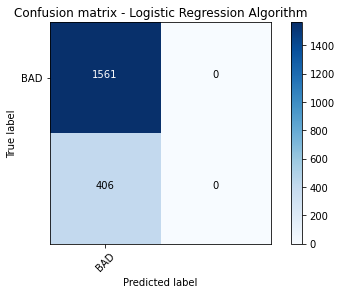

In [36]:
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"],
                      title='Confusion matrix - Logistic Regression Algorithm')

plt.show()

accuracy score :  0.8647686832740213
f1 score :  0.7860767670820659
precision score :  0.7975789895858825
recall score :  0.7762928273211248
Confusion matrix, without normalization
[[1447  114]
 [ 152  254]]


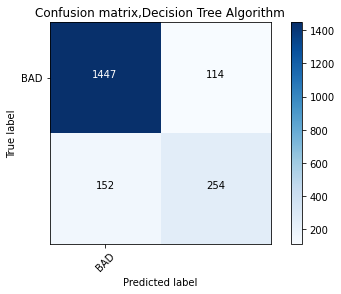

In [37]:
# importing the required modules
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

dectree_basic = DecisionTreeClassifier()
dectree_basic.max_depth = 100
# Training the basic Decision Tree model with training set 
dectree_basic.fit(x_basic_tr,y_tr)

# Predicting the output of the test cases using the algorithm created above
y_pre = dectree_basic.predict(x_basic_te)

# Validating the algorithm using various Performance metrics

a2 = accuracy_score(y_te,y_pre)
f2 = f1_score(y_te, y_pre, average="macro")
p2 = precision_score(y_te, y_pre, average="macro")
r2 = recall_score(y_te, y_pre, average="macro")
print("accuracy score : ",a2)
print("f1 score : ",f2)
print("precision score : ",p2)
print("recall score : ",r2)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"],
                      title='Confusion matrix,Decision Tree Algorithm')

plt.show()




#### Some discussion on Performance metrics :
- Generally Accuracy test can be used to evaluate algorithms. But in this case,just using the MAJORITY CLASS(0) to predict the output will give high(79.2%) accuracy.BUT WE WOULD END UP PREDICTING ALL "1" AS O's INSTEAD.
<br>
- Hence other performance metrics must be used to evaluate the model.And those would be
    - F1 score : Weighted mean of Recall and Precision
    - Recall : (TP/TP+FN)
    - Precision : (TP/TP+FP)
      TP is true positive,FN is false negative,FP is false positive
<br>
- Here we want to decrease the number of False Negatives i.e, We predict that credit will be repaid but it actually being a fraudant one.To decrease FN implies to increase Recall.Therefore, RECALL will the perfect Performance metric to evaluate this model.
<br>
- Precsion may decrease in the process to increase recall but it is okay to predict some extra False Positives.
##### We can also RESAMPLE the data(We will get back to this at the end).

#### Conclusions :

- Using Logistic Regression though Accuracy is good(79%), the model did not perform well on other performance metrics.Recal is just above .5 and this is not good.This may be due to overfitting and we will try to remove this in the next section.
<br>
- Surprisingly,Decision Tree algorithm worked very well compared to Logistic Regression with a RECALL of about .78 and very good ACCURACY.This is beacause this model implicitly performs variable selection/feature selection by spliting the top nodes based on the most important features of the data and feature selection is done automatically.
<br>
- Finally what I want say that is :
    - There will be a good improvement in Logistic Regression model after Feature Selection.
    - The results will almost stay same in the case of Decision Tree model even after Feature Selection.
<br>
- We will prove the above hypothesis by creating models with selected features and compare them will the above models.

# Feature transformation

- Before Feature selection,As discussed in the section "Distribution of various Features" we need to transform some variables in order to improve predictability.
- We have transform the whole data set not just training set.

In [38]:
# Capping off the features CLAGE(values >= 600 to 600) , VALUE(values>=400000 to 400000) , MORTDUE(values>=300000 to 300000) and DEBTINC(values >=100 to 100)

df.loc[df["CLAGE"]>=600,"CLAGE"] = 600
df.loc[df["VALUE"]>=400000,"VALUE"] = 400000
df.loc[df["MORTDUE"]>=300000,"MORTDUE"] = 300000
df.loc[df["DEBTINC"]>=100,"DEBTINC"] = 100

In [39]:
# Creating new binary vaiables B_DEROG,B_DELINQ from DEROG,DELINQ

df["B_DEROG"] = (df["DEROG"]>=1)*1
df["B_DELINQ"] = (df["DELINQ"]>=1)*1

In [40]:
df["JOB"].unique()

array(['Other', 'Office', 'Sales', 'Mgr', 'ProfExe', 'Self'], dtype=object)

In [41]:
# We need to convert the nominal features JOB and REASON into usable form and remove them from the data table

df["REASON_1"] = (df["REASON"] == "HomeImp")*1
df["REASON_2"] = (df["REASON"] != "HomeImp")*1
df["JOB_1"] = (df["JOB"]=="Other")*1
df["JOB_2"] = (df["JOB"]=="Office")*1
df["JOB_3"] = (df["JOB"]=="Sales")*1
df["JOB_4"] = (df["JOB"]=="Mgr")*1
df["JOB_5"] = (df["JOB"]=="ProfExe")*1
df["JOB_6"] = (df["JOB"]=="Self")*1
df.drop(["JOB","REASON"],axis = 1,inplace = True)

# The above assignment creates new features for each JOB and each REASON

In [42]:
# We need to decrease the skewness of the feature YOJ,For that we can apply log of YOJ but since some of them are 0, we will use log(YOJ+constant)

df["YOJ"] = df["YOJ"].apply(lambda t : np.log(t+1))

In [43]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,B_DEROG,B_DELINQ,REASON_1,REASON_2,JOB_1,JOB_2,JOB_3,JOB_4,JOB_5,JOB_6
0,1,1100,25860.0000,39025.000000,2.442347,0.0,0.0,94.366667,1.000000,9.000000,33.779915,0,0,1,0,1,0,0,0,0,0
1,1,1300,70053.0000,68400.000000,2.079442,0.0,2.0,121.833333,0.000000,14.000000,33.779915,0,1,1,0,1,0,0,0,0,0
2,1,1500,13500.0000,16700.000000,1.609438,0.0,0.0,149.466667,1.000000,10.000000,33.779915,0,0,1,0,1,0,0,0,0,0
3,1,1500,73760.8172,101776.048741,2.294782,0.0,0.0,179.766275,1.186055,21.296096,33.779915,0,0,0,1,1,0,0,0,0,0
4,0,1700,97800.0000,112000.000000,1.386294,0.0,0.0,93.333333,0.000000,14.000000,33.779915,0,0,1,0,0,1,0,0,0,0


# Feature selection

- As we completed the transformation part, now we move on to Feature Selection.Now we will find out the most import features that are affecting the target variable "BAD" the most.
- We will use the following for this purpose :
    - Pearson correlation factor pearson
    - chi square test
    - f_regression
    - f_classif 

### Using Pearson Correlation factor for feature selection

In [44]:
# Finding correlation between all the features and the target feature "BAD"

df.corr(method='pearson') 

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,B_DEROG,B_DELINQ,REASON_1,REASON_2,JOB_1,JOB_2,JOB_3,JOB_4,JOB_5,JOB_6
BAD,1.000000,-0.075099,-0.049420,-0.043711,-0.053066,0.269921,0.346503,-0.173412,0.168851,-0.004067,0.122494,0.261216,0.308153,0.037517,-0.037517,0.037949,-0.073613,0.050934,0.032583,-0.043561,0.046245
LOAN,-0.075099,1.000000,0.214803,0.338749,0.102458,0.006996,-0.028869,0.088875,0.043160,0.071804,0.074101,0.009079,-0.030646,-0.151477,0.151477,-0.058067,-0.018060,-0.044993,0.018769,0.017488,0.158452
MORTDUE,-0.049420,0.214803,1.000000,0.816001,-0.052771,-0.046526,0.002095,0.132928,0.026853,0.314779,0.132220,-0.041471,-0.014568,-0.026941,0.026941,-0.259602,-0.066813,0.026023,0.076687,0.256575,0.107944
VALUE,-0.043711,0.338749,0.816001,1.000000,0.023878,-0.041263,-0.000578,0.178638,-0.004635,0.283654,0.120090,-0.040482,-0.034988,-0.012308,0.012308,-0.288132,-0.058463,0.018250,0.051960,0.282653,0.163060
YOJ,-0.053066,0.102458,-0.052771,0.023878,1.000000,-0.050552,0.023185,0.145111,-0.052621,0.042928,-0.049355,-0.058295,0.023075,0.060306,-0.060306,0.023324,-0.066539,-0.041243,0.029926,0.024664,-0.010586
DEROG,0.269921,0.006996,-0.046526,-0.041263,-0.050552,1.000000,0.171286,-0.081231,0.146700,0.050727,0.011852,0.755021,0.171622,-0.008406,0.008406,0.034537,-0.049223,0.030659,0.031342,-0.033939,0.000836
DELINQ,0.346503,-0.028869,0.002095,-0.000578,0.023185,0.171286,1.000000,0.026713,0.057212,0.159378,0.036862,0.188767,0.748356,0.004024,-0.004024,-0.044718,0.005268,-0.016502,0.059350,-0.002911,0.021694
CLAGE,-0.173412,0.088875,0.132928,0.178638,0.145111,-0.081231,0.026713,1.000000,-0.110857,0.242213,-0.038756,-0.083332,0.007707,0.050670,-0.050670,-0.080490,0.000032,0.026502,-0.022948,0.112309,-0.010872
NINQ,0.168851,0.043160,0.026853,-0.004635,-0.052621,0.146700,0.057212,-0.110857,1.000000,0.085148,0.118993,0.152237,0.059767,-0.115992,0.115992,0.054470,-0.063735,-0.035677,0.069826,-0.061553,0.016229
CLNO,-0.004067,0.071804,0.314779,0.283654,0.042928,0.050727,0.159378,0.242213,0.085148,1.000000,0.168998,0.035880,0.154674,-0.107224,0.107224,-0.197815,-0.004549,0.049185,0.060210,0.165109,0.031325


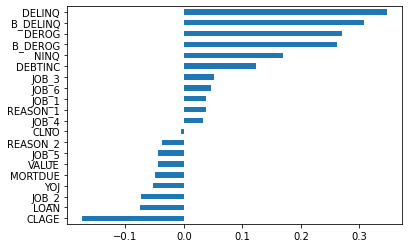

In [45]:
correlations = df.corr(method='pearson')['BAD'].drop('BAD')

correlations.sort_values().plot(kind = 'barh')

In [46]:
# Gathering the 2 feature sets with high peason correlation value,one with 7 and other with 10 features in it

feat1=["DELINQ", "B_DELINQ","DEROG","B_DEROG","NINQ", "DEBTINC","LOAN", "JOB_3", "JOB_6", "JOB_1"]

##### Now that we got the features with high correlation with the BAD feature, we will run the classification algorithms and compare them

accuracy score :  0.820538891713269
f1 score :  0.6319613065659577
precision score :  0.7530842178841402
recall score :  0.6108319158806247
Confusion matrix, without normalization
[[1511   50]
 [ 303  103]]


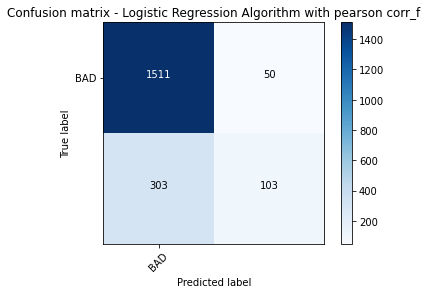

In [47]:
# Logistic Regression using above feature set 1

x = df[feat1]
y = df["BAD"]
x_tr,x_te,y_tr,y_te = train_test_split(x,y,test_size = 0.33,random_state=1)
logreg = LogisticRegression()
logreg.fit(x_tr,y_tr)
y_pre = logreg.predict(x_te)
a3 = accuracy_score(y_te,y_pre)
f3 = f1_score(y_te, y_pre, average="macro")
p3 = precision_score(y_te, y_pre, average="macro")
r3 = recall_score(y_te, y_pre, average="macro")
print("accuracy score : ",a3)
print("f1 score : ",f3)
print("precision score : ",p3)
print("recall score : ",r3)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"],
title='Confusion matrix - Logistic Regression Algorithm with pearson corr_f')

plt.show()

accuracy score :  0.8307066598881545
f1 score :  0.7350241609407899
precision score :  0.7414779713284994
recall score :  0.7293180763878151

Confusion matrix, without normalization
[[1408  153]
 [ 180  226]]


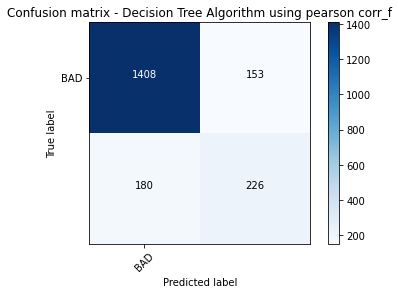

In [48]:
# Decision Tree classifier using feat1

clf_tree=DecisionTreeClassifier()
clf_tree.max_depth = 100
clf_tree.fit(x_tr,y_tr)
y_pre = clf_tree.predict(x_te)
a4 = accuracy_score(y_te,y_pre)
f4 = f1_score(y_te, y_pre, average="macro")
p4 = precision_score(y_te, y_pre, average="macro")
r4 = recall_score(y_te, y_pre, average="macro")
print("accuracy score : ",a4)
print("f1 score : ",f4)
print("precision score : ",p4)
print("recall score : ",r4)
print("")
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"],
title='Confusion matrix - Decision Tree Algorithm using pearson corr_f')

plt.show()

### Using chi2 test for feature selection

In [49]:
# Finding the best 10 features using chi2 test

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
df_new = pd.DataFrame(SelectKBest(chi2, k=10).fit_transform(df.drop(["BAD"],axis = 1),df["BAD"]))

In [50]:
# dataframe containing the selected features

df_new.head()

,0,1,2,3,4,5,6,7,8,9
0,1100.0,25860.0000,39025.000000,0.0,0.0,94.366667,1.000000,33.779915,0.0,0.0
1,1300.0,70053.0000,68400.000000,0.0,2.0,121.833333,0.000000,33.779915,0.0,1.0
2,1500.0,13500.0000,16700.000000,0.0,0.0,149.466667,1.000000,33.779915,0.0,0.0
3,1500.0,73760.8172,101776.048741,0.0,0.0,179.766275,1.186055,33.779915,0.0,0.0
4,1700.0,97800.0000,112000.000000,0.0,0.0,93.333333,0.000000,33.779915,0.0,0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy score :  0.7935943060498221
f1 score :  0.44246031746031744
precision score :  0.39679715302491103
recall score :  0.5
Confusion matrix, without normalization
[[1561    0]
 [ 406    0]]


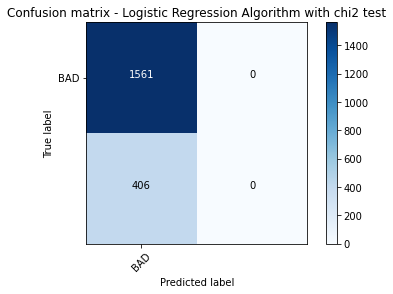

In [51]:
# Running the logistic regression algorithm using the features selected from chi2 test

x = df_new
y = df["BAD"]
x_tr,x_te,y_tr,y_te = train_test_split(x,y,test_size = .33,random_state=1)
logreg = LogisticRegression()
logreg.fit(x_tr,y_tr)
y_pre = logreg.predict(x_te)
y_pre = logreg.predict(x_te)
a5 = accuracy_score(y_te,y_pre)
f5 = f1_score(y_te, y_pre, average="macro")
p5 = precision_score(y_te, y_pre, average="macro")
r5 = recall_score(y_te, y_pre, average="macro")
print("accuracy score : ",a5)
print("f1 score : ",f5)
print("precision score : ",p5)
print("recall score : ",r5)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"],
 title='Confusion matrix - Logistic Regression Algorithm with chi2 test')

plt.show()


accuracy score :  0.8632435180477885
f1 score :  0.7855399145520507
precision score :  0.7939934604540981
recall score :  0.7780655636307406
Confusion matrix, without normalization
[[1441  120]
 [ 149  257]]


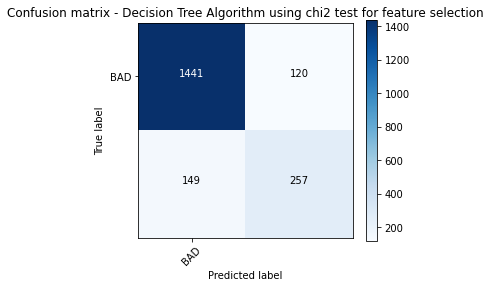

In [52]:
# Decision Tree classifier using features from chi2 test

clf_tree=DecisionTreeClassifier()
clf_tree.max_depth = 100
clf_tree.fit(x_tr,y_tr)
y_pre = clf_tree.predict(x_te)
a6 = accuracy_score(y_te,y_pre)
f6 = f1_score(y_te, y_pre, average="macro")
p6 = precision_score(y_te, y_pre, average="macro")
r6 = recall_score(y_te, y_pre, average="macro")
print("accuracy score : ",a6)
print("f1 score : ",f6)
print("precision score : ",p6)
print("recall score : ",r6)
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"],
title='Confusion matrix - Decision Tree Algorithm using chi2 test for feature selection')

plt.show()

In [53]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,B_DEROG,B_DELINQ,REASON_1,REASON_2,JOB_1,JOB_2,JOB_3,JOB_4,JOB_5,JOB_6
0,1,1100,25860.0000,39025.000000,2.442347,0.0,0.0,94.366667,1.000000,9.000000,33.779915,0,0,1,0,1,0,0,0,0,0
1,1,1300,70053.0000,68400.000000,2.079442,0.0,2.0,121.833333,0.000000,14.000000,33.779915,0,1,1,0,1,0,0,0,0,0
2,1,1500,13500.0000,16700.000000,1.609438,0.0,0.0,149.466667,1.000000,10.000000,33.779915,0,0,1,0,1,0,0,0,0,0
3,1,1500,73760.8172,101776.048741,2.294782,0.0,0.0,179.766275,1.186055,21.296096,33.779915,0,0,0,1,1,0,0,0,0,0
4,0,1700,97800.0000,112000.000000,1.386294,0.0,0.0,93.333333,0.000000,14.000000,33.779915,0,0,1,0,0,1,0,0,0,0


### Using f_classif for feature selection

In [54]:
from sklearn.feature_selection import f_classif

df_new2 = pd.DataFrame(SelectKBest(f_classif, k=10).fit_transform(df.drop(["BAD"],axis=1),df["BAD"]))
df_new2.head()

,0,1,2,3,4,5,6,7,8,9
0,1100.0,2.442347,0.0,0.0,94.366667,1.000000,33.779915,0.0,0.0,0.0
1,1300.0,2.079442,0.0,2.0,121.833333,0.000000,33.779915,0.0,1.0,0.0
2,1500.0,1.609438,0.0,0.0,149.466667,1.000000,33.779915,0.0,0.0,0.0
3,1500.0,2.294782,0.0,0.0,179.766275,1.186055,33.779915,0.0,0.0,0.0
4,1700.0,1.386294,0.0,0.0,93.333333,0.000000,33.779915,0.0,0.0,1.0


accuracy score :  0.8256227758007118
f1 score :  0.6496716000650101
precision score :  0.7634780439121757
recall score :  0.6249696260133867
Confusion matrix, without normalization
[[1509   52]
 [ 291  115]]


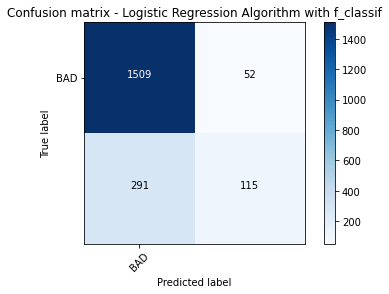

In [55]:
# Running the logistic regression algorithm using the features selected from f_classif test

x = df_new2
y = df["BAD"]
x_tr,x_te,y_tr,y_te = train_test_split(x,y,test_size = .33,random_state=1)
logreg = LogisticRegression()
logreg.fit(x_tr,y_tr)
y_pre = logreg.predict(x_te)
a7 = accuracy_score(y_te,y_pre)
f7 = f1_score(y_te, y_pre, average="macro")
p7 = precision_score(y_te, y_pre, average="macro")
r7 = recall_score(y_te, y_pre, average="macro")
print("accuracy score : ",a7)
print("f1 score : ",f7)
print("precision score : ",p7)
print("recall score : ",r7)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"],
title='Confusion matrix - Logistic Regression Algorithm with f_classif')

plt.show()

accuracy score :  0.8571428571428571
f1 score :  0.7793386070706405
precision score :  0.7828202243194919
recall score :  0.7760443128851975
Confusion matrix, without normalization
[[1427  134]
 [ 147  259]]


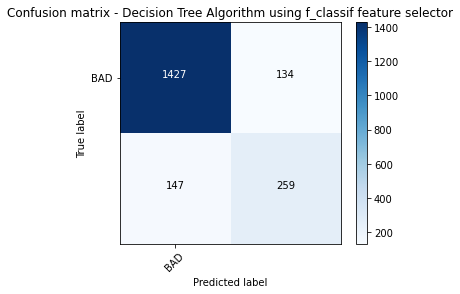

In [56]:
# Decision Tree classifier using features from f_classif test

clf_tree=DecisionTreeClassifier()
clf_tree.max_depth = 100
clf_tree.fit(x_tr,y_tr)
y_pre = clf_tree.predict(x_te)
a8 = accuracy_score(y_te,y_pre)
f8 = f1_score(y_te, y_pre, average="macro")
p8 = precision_score(y_te, y_pre, average="macro")
r8 = recall_score(y_te, y_pre, average="macro")
print("accuracy score : ",a8)
print("f1 score : ",f8)
print("precision score : ",p8)
print("recall score : ",r8)
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"],
                      title='Confusion matrix - Decision Tree Algorithm using f_classif feature selector')

plt.show()

#### To view the decision tree created - 

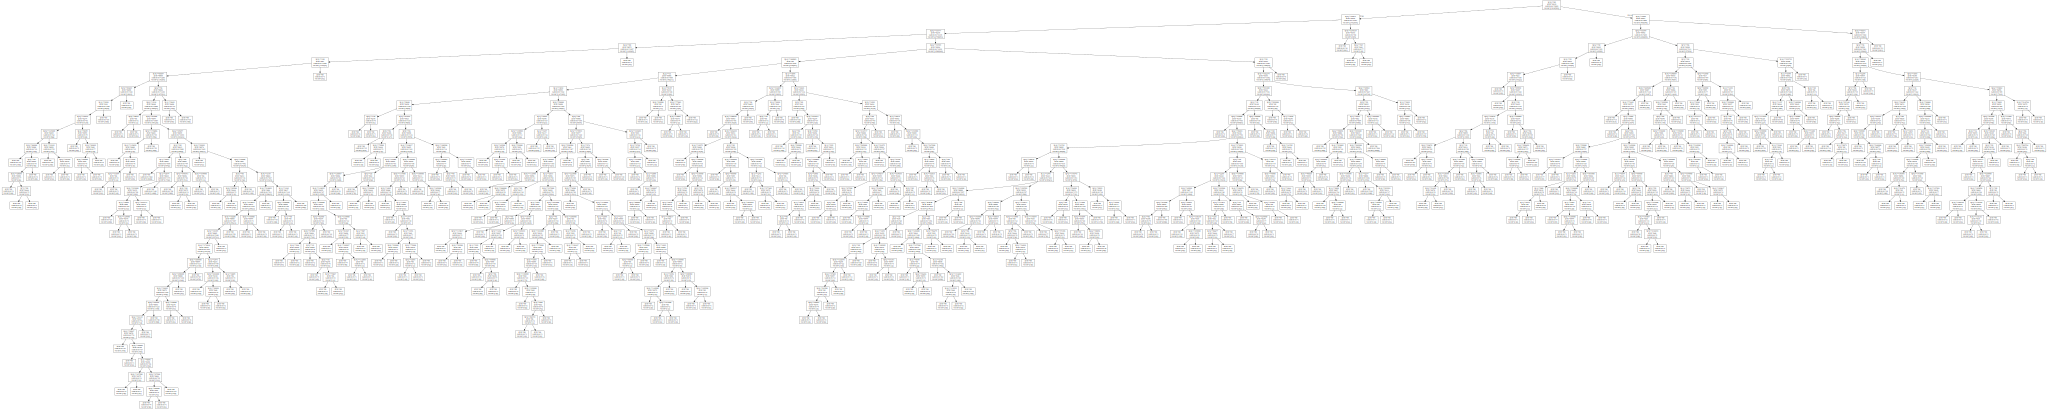

In [57]:
from sklearn import tree
import graphviz 
dot_dat = tree.export_graphviz(clf_tree, out_file=None) 
graph = graphviz.Source(dot_dat) 
graph

### Using f_regression for feature selection

In [58]:
from sklearn.feature_selection import f_regression

df_new3 = pd.DataFrame(SelectKBest(f_regression, k=10).fit_transform(df.drop(["BAD"],axis=1),df["BAD"]))
df_new3.head()

,0,1,2,3,4,5,6,7,8,9
0,1100.0,2.442347,0.0,0.0,94.366667,1.000000,33.779915,0.0,0.0,0.0
1,1300.0,2.079442,0.0,2.0,121.833333,0.000000,33.779915,0.0,1.0,0.0
2,1500.0,1.609438,0.0,0.0,149.466667,1.000000,33.779915,0.0,0.0,0.0
3,1500.0,2.294782,0.0,0.0,179.766275,1.186055,33.779915,0.0,0.0,0.0
4,1700.0,1.386294,0.0,0.0,93.333333,0.000000,33.779915,0.0,0.0,1.0


accuracy score :  0.8256227758007118
f1 score :  0.6496716000650101
precision score :  0.7634780439121757
recall score :  0.6249696260133867
Confusion matrix, without normalization
[[1427  134]
 [ 147  259]]


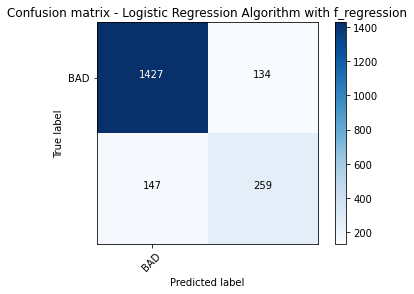

In [59]:
# Running the logistic regression algorithm using the features selected from f_regression test

x = df_new3
y = df["BAD"]
x_tr,x_te,y_tr,y_te = train_test_split(x,y,test_size = .33,random_state=1)
logreg = LogisticRegression()
logreg.fit(x_tr,y_tr)
y_pre2 = logreg.predict(x_te)
a9 = accuracy_score(y_te,y_pre2)
f9 = f1_score(y_te, y_pre2, average="macro")
p9 = precision_score(y_te, y_pre2, average="macro")
r9 = recall_score(y_te, y_pre2, average="macro")
print("accuracy score : ",a9)
print("f1 score : ",f9)
print("precision score : ",p9)
print("recall score : ",r9)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"],
                      title='Confusion matrix - Logistic Regression Algorithm with f_regression')

plt.show()

accuracy score :  0.8647686832740213
f1 score :  0.7901370148726916
precision score :  0.7952410177392712
recall score :  0.7854050233051315
Confusion matrix, without normalization
[[1437  124]
 [ 142  264]]


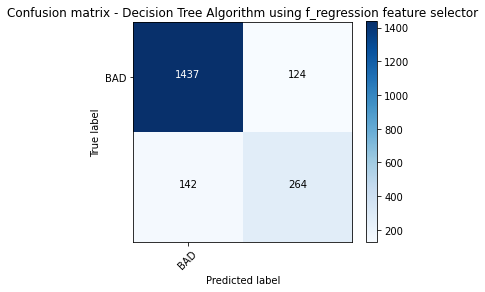

In [60]:
# Decision Tree classifier using features from f_regression test

clf_tree=DecisionTreeClassifier()
clf_tree.max_depth = 100
clf_tree.fit(x_tr,y_tr)
y_pre = clf_tree.predict(x_te)
a10 = accuracy_score(y_te,y_pre)
f10 = f1_score(y_te, y_pre, average="macro")
p10= precision_score(y_te, y_pre, average="macro")
r10 = recall_score(y_te, y_pre, average="macro")
print("accuracy score : ",a10)
print("f1 score : ",f10)
print("precision score : ",p10)
print("recall score : ",r10)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], 
                      title='Confusion matrix - Decision Tree Algorithm using f_regression feature selector')

plt.show()

# Comparing all the models
 - We can now rank our evaluation of all the models to choose the best one for our problem. 

In [61]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree','Logistic Regression', 'Decision Tree','Logistic Regression', 'Decision Tree','Logistic Regression', 'Decision Tree','Logistic Regression', 'Decision Tree'],
    'Feature Selection Method' : ['None','None','Pearson corr_fact','Pearson corr_fact','chi2 test','chi2 test','f_classif','f_classif','f_regression','f_regression'],
    'Accuracy Score': [a1,a2,a3,a4,a5,a6,a7,a8,a9,a10],
    'Recall Score' : [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10],
    'F1 Score' : [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10],
    'Precision Score' : [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10]
})

In [62]:
models

,Model,Feature Selection Method,Accuracy Score,Recall Score,F1 Score,Precision Score
0,Logistic Regression,None,0.793594,0.500000,0.442460,0.396797
1,Decision Tree,None,0.864769,0.776293,0.786077,0.797579
2,Logistic Regression,Pearson corr_fact,0.820539,0.610832,0.631961,0.753084
3,Decision Tree,Pearson corr_fact,0.830707,0.729318,0.735024,0.741478
4,Logistic Regression,chi2 test,0.793594,0.500000,0.442460,0.396797
5,Decision Tree,chi2 test,0.863244,0.778066,0.785540,0.793993
6,Logistic Regression,f_classif,0.825623,0.624970,0.649672,0.763478
7,Decision Tree,f_classif,0.857143,0.776044,0.779339,0.782820
8,Logistic Regression,f_regression,0.825623,0.624970,0.649672,0.763478
9,Decision Tree,f_regression,0.864769,0.785405,0.790137,0.795241


In [63]:
pd.pivot_table(models,index = ["Feature Selection Method","Model"])

Accuracy Score  ...  Recall Score
Feature Selection Method Model                                ...              
None                     Decision Tree              0.864769  ...      0.776293
                         Logistic Regression        0.793594  ...      0.500000
Pearson corr_fact        Decision Tree              0.830707  ...      0.729318
                         Logistic Regression        0.820539  ...      0.610832
chi2 test                Decision Tree              0.863244  ...      0.778066
                         Logistic Regression        0.793594  ...      0.500000
f_classif                Decision Tree              0.857143  ...      0.776044
                         Logistic Regression        0.825623  ...      0.624970
f_regression             Decision Tree              0.864769  ...      0.785405
                         Logistic Regression        0.825623  ...      0.624970

[10 rows x 4 columns]

# Discussion and Insights :
- Logistic Regression produced results with a good accuracy but overall performance is not that good. 
<br>
- Decision Tree dominated over Logistic Regression in all cases.
<br>
- As mentioned earlier, the performance of Decision tree remained almost the same from the start since it does feature selection inheritly.Also performance of Logistic Regression got better after feature selection process.
<br>
- Finally Decision Tree model with feature selector f_classf would be the best method to use because it has the Highest RECALL value
<br>
- The maximum depth of the decision tree is set to 100 in all cases hence number of levels is 101 in all cases.And since we did not set the minimum number of observations in the leaf will be 1 since it is classification problem.
<br>
- The threshold is defaultly set to .5 in Logistic Regression!
<br>
- Obviously,changing the threshold affects the performance of the model and this can be observed in the next section.
<br>
- This can be further extended by Resampling of the data to increase the RECALL score

#### Using decision tree with f_classif feature selector would give the best results!!

# Changing the threshold and observing the performance :

Recall metric in the testing dataset:  0.9088669950738916
Accuracy score for the testing dataset:  0.5043213014743264
Confusion matrix, without normalization
[[623 938]
 [ 37 369]]

Recall metric in the testing dataset:  0.6674876847290641
Accuracy score for the testing dataset:  0.7391967463141841
Confusion matrix, without normalization
[[1183  378]
 [ 135  271]]

Recall metric in the testing dataset:  0.5
Accuracy score for the testing dataset:  0.8093543467208948
Confusion matrix, without normalization
[[1389  172]
 [ 203  203]]

Recall metric in the testing dataset:  0.3669950738916256
Accuracy score for the testing dataset:  0.8235892221657346
Confusion matrix, without normalization
[[1471   90]
 [ 257  149]]

Recall metric in the testing dataset:  0.2832512315270936
Accuracy score for the testing dataset:  0.8256227758007118
Confusion matrix, without normalization
[[1509   52]
 [ 291  115]]

Recall metric in the testing dataset:  0.22167487684729065
Accuracy score for the testing

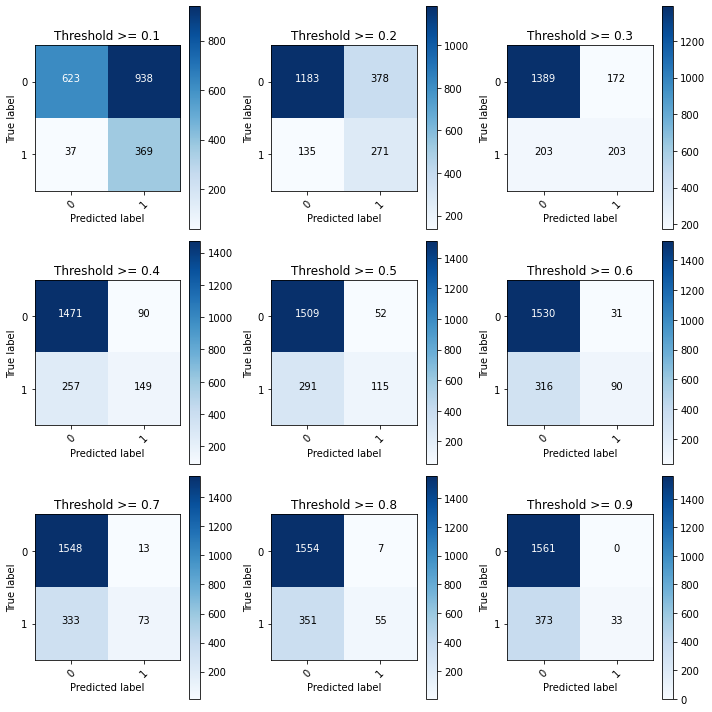

In [64]:
lr = LogisticRegression()
lr.fit(x_tr,y_tr)
y_pred_proba = lr.predict_proba(x_te)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_proba[:,1] >= i
    
    plt.subplot(3,3,j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_te,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)
    rec1 = recall_score(y_te, y_test_predictions_high_recall)
    acc= 1.0*(cnf_matrix[0,0]+cnf_matrix[1,1])/(cnf_matrix[0,0]+cnf_matrix[1,0]+cnf_matrix[1,1]+cnf_matrix[0,1])
    print("Recall metric in the testing dataset: ",rec1)
    print("Accuracy score for the testing dataset: ",acc)
    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i)
    print("")

#### Conclusion :
- The values of recall and accuracy vary with the threshold selected.
- Based on the required accuracy and recall values , one has to decide and select a threshold.
- It is suggested to move on with the default threshold that is 0.5 in general cases.
<br>
------------------------------------------------------------------------------------------------------------------------------